In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold

Следующий блок добавлен на случай, если у вас проблемы с версиями polars, catboost, или в целом с .parquet файлами.

В случае конфликта версий catboost и polars при создании Pool, может потребоваться использовать fallback функцию to_pandas(). Более нигде pandas далее не используется.

In [2]:
import pandas as pd

try:
    import pyarrow
    print("PyArrow is installed. Version:", pyarrow.__version__)
except ModuleNotFoundError:
    print("PyArrow is NOT found in this environment. You installed it in a different one.")

PyArrow is installed. Version: 18.1.0


### Часть 1, смотрим данные

Сперва подгрузим данные и посмотрим с чем нам предстоит работать. 

Участникам предоставляются 2 пары файлов с признаками (train и test):

1. train_main_features.parquet + test_main_features.parquet (199 признаков + ключ)
2. train_extra_features.parquet + test_extra_features.parquet (2241 признак + ключ)


##### Часть 1.1 данные признаков

Попробуем сперва поработать с первым набором (*_main_features.parquet*).

In [3]:
train = pl.read_parquet('data/train_main_features.parquet')
test = pl.read_parquet('data/test_main_features.parquet')

print('Тренировочные данные:', train.shape)
print('Тестовые данные:', test.shape)

Тренировочные данные: (750000, 200)
Тестовые данные: (250000, 200)


In [4]:
train.head(n = 5)

customer_id,cat_feature_1,cat_feature_2,cat_feature_3,cat_feature_4,cat_feature_5,cat_feature_6,cat_feature_7,cat_feature_8,cat_feature_9,cat_feature_10,cat_feature_11,cat_feature_12,cat_feature_13,cat_feature_14,cat_feature_15,cat_feature_16,cat_feature_17,cat_feature_18,cat_feature_19,cat_feature_20,cat_feature_21,cat_feature_22,cat_feature_23,cat_feature_24,cat_feature_25,cat_feature_26,cat_feature_27,cat_feature_28,cat_feature_29,cat_feature_30,cat_feature_31,cat_feature_32,cat_feature_33,cat_feature_34,cat_feature_35,cat_feature_36,…,num_feature_96,num_feature_97,num_feature_98,num_feature_99,num_feature_100,num_feature_101,num_feature_102,num_feature_103,num_feature_104,num_feature_105,num_feature_106,num_feature_107,num_feature_108,num_feature_109,num_feature_110,num_feature_111,num_feature_112,num_feature_113,num_feature_114,num_feature_115,num_feature_116,num_feature_117,num_feature_118,num_feature_119,num_feature_120,num_feature_121,num_feature_122,num_feature_123,num_feature_124,num_feature_125,num_feature_126,num_feature_127,num_feature_128,num_feature_129,num_feature_130,num_feature_131,num_feature_132
i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1000001,1.0,0.0,2.0,1.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,0.0,0.0,212.0,0.0,0.0,…,-0.284519,null,-0.004499,null,-0.050159,-0.002297,-0.043592,-0.061488,0.450342,null,0.0,null,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,null,-0.493959,-0.019079,null,null,null,null,-0.001357,-0.031281,-0.046146,null,-0.445279,null,null,-0.107666,-0.418616,null,null
1000002,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,212.0,1.0,0.0,…,-0.284519,0.460275,-0.004278,null,-0.556244,-0.002297,-0.043592,-0.061488,1.998252,-0.009552,0.0,-0.005762,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,-0.004421,-0.256445,-0.014154,null,-0.24167,null,null,-0.001357,-0.031281,-0.046146,-0.10217,1.550722,null,null,-0.170724,-0.805771,-0.397803,-0.373734
1000003,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,212.0,0.0,0.0,…,-0.284519,-0.264397,-0.004278,null,null,-0.002297,-0.043592,-0.061488,-0.264078,null,0.0,-0.26649,-0.060492,-0.279105,null,-0.429813,null,-0.009654,-0.293036,-0.004421,-0.57313,-0.019124,null,-0.24167,null,null,-0.001357,-0.031281,-0.046146,null,-0.475778,null,null,-0.170724,-0.602005,-0.397803,-0.373734
1000004,1.0,0.0,2.0,1.0,2.0,3.0,2.0,2.0,3.0,2.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,212.0,0.0,0.0,…,-0.284519,null,-0.004499,null,null,-0.002297,-0.043592,-0.061488,0.688482,-0.009552,0.0,null,-0.060492,null,null,-0.429813,null,-0.009654,-0.293036,null,-0.57313,null,null,-0.505441,null,0.714631,-0.001357,-0.031281,-0.046146,null,-0.475778,0.111196,0.116695,null,-0.724265,null,null
1000005,1.0,2.0,0.0,1.0,0.0,3.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,212.0,2.0,2.0,…,-0.284519,-0.264397,-0.004499,null,null,-0.002297,-0.043592,null,-0.264078,null,0.0,-0.26649,null,-0.279105,null,-0.429813,null,-0.009654,-0.293036,-0.004421,-0.57313,-0.018674,null,null,null,null,null,null,-0.046146,null,null,null,null,-0.107666,null,-0.397803,-0.373734


Легенда гласит, что в данных достаточно много пропусков. 

Так ли это?

In [5]:
missing_values = (
    train.null_count()
    .unpivot(variable_name="Column", value_name="Missing Values")
    .filter(pl.col("Missing Values") > 0)
    .sort("Missing Values", descending=True)
)

print('\nКоличество пропусков в признаках:\n', missing_values)


Количество пропусков в признаках:
 shape: (132, 2)
┌─────────────────┬────────────────┐
│ Column          ┆ Missing Values │
│ ---             ┆ ---            │
│ str             ┆ u32            │
╞═════════════════╪════════════════╡
│ num_feature_43  ┆ 749166         │
│ num_feature_54  ┆ 748897         │
│ num_feature_64  ┆ 748761         │
│ num_feature_34  ┆ 748228         │
│ num_feature_118 ┆ 747082         │
│ …               ┆ …              │
│ num_feature_27  ┆ 31045          │
│ num_feature_58  ┆ 18722          │
│ num_feature_76  ┆ 18542          │
│ num_feature_62  ┆ 18540          │
│ num_feature_98  ┆ 3215           │
└─────────────────┴────────────────┘


Нам также известно, что часть признаков в данных — категориальная. 
По легенде их можно найти по названиям "cat_feature".

Эти категориальные признаки стоит отдельно выделить и сохранить для Catboost. 

In [6]:
cat_feature_names = [
    col_name for col_name in train.columns 
    if col_name.startswith("cat_feature")
]

In [7]:
train = train.with_columns(
    pl.col(cat_feature_names).cast(pl.Int32)
)


##### Часть 1.2 целевые переменные

В задаче предоставлена информация о 41 банковском продукте. 

Информацию о наличии каждого продукта требуется классифицровать по отдельности, в рамках multi-label постановки.

In [8]:
target = pl.read_parquet('data/train_target.parquet')

In [9]:
target.head(n = 5)

customer_id,target_1_1,target_1_2,target_1_3,target_1_4,target_1_5,target_2_1,target_2_2,target_2_3,target_2_4,target_2_5,target_2_6,target_2_7,target_2_8,target_3_1,target_3_2,target_3_3,target_3_4,target_3_5,target_4_1,target_5_1,target_5_2,target_6_1,target_6_2,target_6_3,target_6_4,target_6_5,target_7_1,target_7_2,target_7_3,target_8_1,target_8_2,target_8_3,target_9_1,target_9_2,target_9_3,target_9_4,target_9_5,target_9_6,target_9_7,target_9_8,target_10_1
i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Давайте поверхностно посмотрим на то. с чем нам предстоит работать

In [10]:
target_columns = [col for col in target.columns if col.startswith("target")]

In [11]:
target_col_means = (
    target.select(pl.col(target_columns).mean())
    .transpose(include_header = True, column_names = ["Mean"])
    .rename({"column": "Target"})
    #.sort("Sum", descending=True)
)

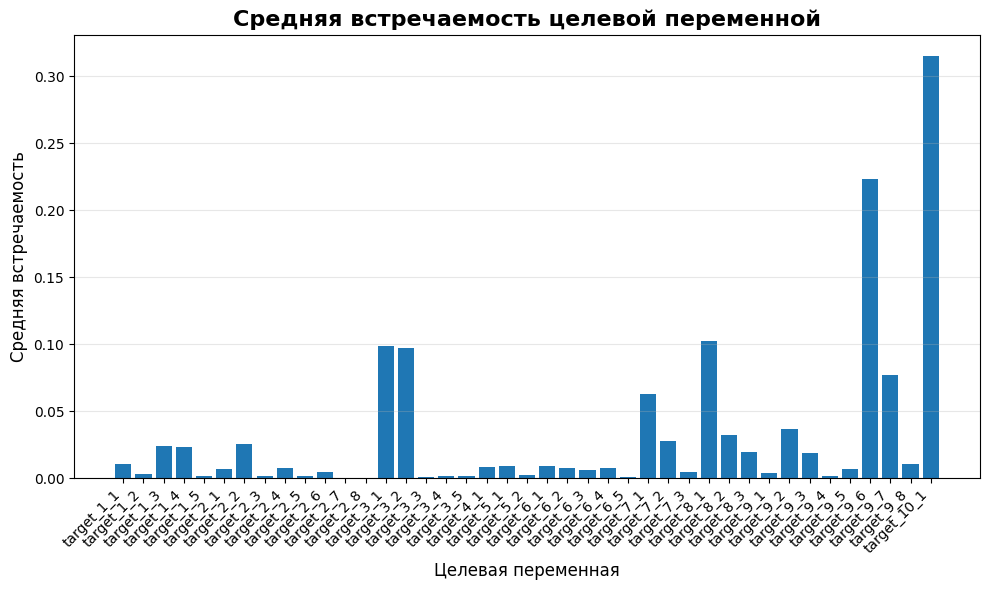

In [12]:
plt.figure(figsize = (10, 6))

bars = plt.bar(target_col_means["Target"], target_col_means["Mean"])

plt.title("Средняя встречаемость целевой переменной", fontsize = 16, fontweight='bold')
plt.xlabel("Целевая переменная", fontsize = 12)
plt.ylabel("Средняя встречаемость", fontsize = 12)
plt.xticks(rotation = 45, ha = 'right', fontsize = 10)
plt.grid(axis = 'y', alpha = 0.3)

plt.tight_layout()
plt.show()

Выглядит интересно. И несбалансированно :)

Интересно, а что у них с совместной встречаемостью?

In [13]:
target_row_sums = target.select(
    pl.sum_horizontal(target_columns).alias("row_sum")
)

target_row_sums.describe()

statistic,row_sum
str,f64
"""count""",750000.0
"""null_count""",0.0
"""mean""",1.303459
"""std""",0.716945
"""min""",1.0
"""25%""",1.0
"""50%""",1.0
"""75%""",1.0
"""max""",11.0


In [14]:
target_corr_matrix = (
    target.select(target_columns)
    .corr()
    .to_numpy()
)

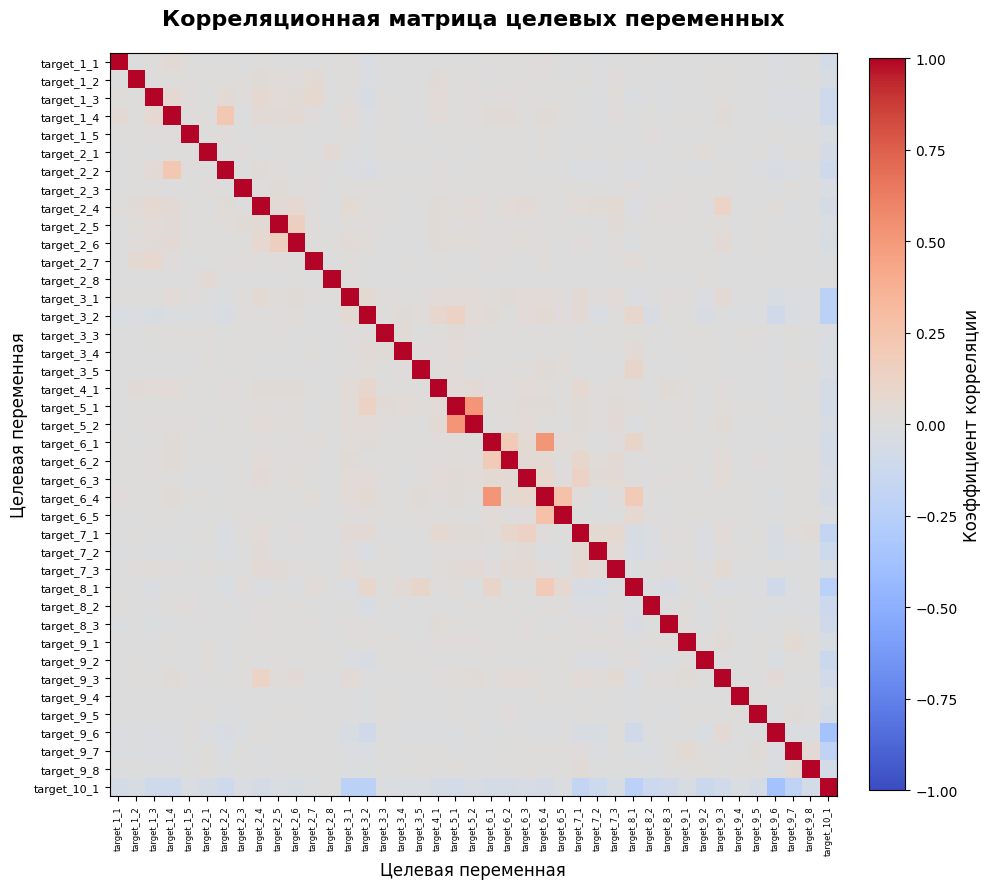

In [15]:
plt.figure(figsize=(10, 9))
im = plt.imshow(target_corr_matrix, cmap = 'coolwarm', vmin = -1, vmax = 1, aspect = 'auto')

cbar = plt.colorbar(im, fraction = 0.046, pad = 0.04)
cbar.set_label('Коэффициент корреляции', fontsize = 12)

plt.title("Корреляционная матрица целевых переменных", fontsize = 16, fontweight = 'bold', pad = 20)
plt.xlabel("Целевая переменная", fontsize = 12)
plt.ylabel("Целевая переменная", fontsize = 12)

plt.xticks(np.arange(len(target_columns)), target_columns, rotation = 90, fontsize = 6)
plt.yticks(np.arange(len(target_columns)), target_columns, fontsize = 8)

plt.tight_layout()
plt.show()

Кажется, тут есть с чем можно работать. 

- На первый взгляд, есть выделяющаяся target_10_1 с отрицательной корреляцией к остальным целевым переменным.
- Внутри целевых переменных с 3 по 7 группу есть заметная внутри-групповая корреляция.
- Небольшая корреляция есть и между целевыми переменными из 1 и 2 групп, в частности между target_1_4 и target_2_2.

В дальнейшей работе это все можно было бы учесть и покопать глубже. Но сейчас нужно подготовить решение :)

### Часть 2, обучаем Catboost

К счастью для нас, Catboost умеет "из коробки" работать и с пропусками, и (важно для нас) с multi-class и multi-label классификацией.

Попробуем обучить модель "в лоб", оставив более интересные возможности и надстройки для участников соревнования :)


##### Часть 2.1 подготовка данных

- Опустим сам customer_id
- Не забудем про ранее сохраненные категориальные признаки
- Найдем в документации Catboost настройку "MultiLogLoss"
- Будем осторожны в первом подходе к снаряду, так как деревьев будет строиться много

In [16]:
train_pool = Pool(data = train.drop("customer_id").to_pandas(), 
                  label = target.drop("customer_id").to_pandas(), 
                  cat_features = cat_feature_names)

In [17]:
# model = CatBoostClassifier(
#     iterations=1000,
#     depth=6,
#     learning_rate=0.1,
#     loss_function="MultiLogloss",
#     random_seed=42,
#     verbose=100,
#     task_type="GPU",
#     devices="0,1"

# )

### Score LB = 0,8228511203460567

Поехали :)

P.S. Это займет какое-то время, так что можно сходить попить чай

In [18]:
# model.fit(train_pool, use_best_model=True, plot=True)

Настройку валидации и гиперпараметров оставим уже для участников соревнования 🤗

### Часть 3, подготовка сабмита

Посмотрим на пример рабочего бейзлайн решения. 

Именно в таком формате платформа ждет от нас решения:

In [19]:
sample_submit = pl.read_parquet('data/sample_submit.parquet')

test = test.with_columns(
    pl.col(cat_feature_names).cast(pl.Int32)
)
test_pool = Pool(data = test.drop("customer_id").to_pandas(), 
                 cat_features = cat_feature_names)


In [20]:
X = train.drop("customer_id").to_pandas()
y = target.drop("customer_id").to_pandas() 


In [21]:
# pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [22]:
fold_results = []

for fold, (train_idx, val_idx) in enumerate(mskf.split(X, y), 1):
    print(f"\n========== Fold {fold} ==========")

    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_pool = Pool(
        data=X_tr,
        label=y_tr,
        cat_features=cat_feature_names
    )

    val_pool = Pool(
        data=X_val,
        label=y_val,
        cat_features=cat_feature_names
    )


    model = CatBoostClassifier(
            iterations=2000,
            depth=6,
            learning_rate=0.1,
            loss_function="MultiLogloss",      # мультиклассовый логлосс
            eval_metric="MultiLogloss", 
            random_seed=42,
            verbose=100,
            early_stopping_rounds=300,
            task_type="GPU",        
            devices="0",
        )

    model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        early_stopping_rounds=200
    )

    # вероятности по классам
    val_pred = model.predict_proba(val_pool)

    # macro ROC-AUC (OvR)
    val_auc = roc_auc_score(y_val, val_pred, average="macro")

    print(f"Fold {fold} | macro ROC-AUC: {val_auc:.5f}")

    # предсказания на тест
    fold_pred = model.predict_proba(test_pool)

    # сохраняем результат
    fold_results.append({
        "fold": fold,
        "auc": val_auc,
        "pred": fold_pred
    })

# сортируем по AUC и выбираем топ-5
top_folds = sorted(fold_results, key=lambda x: x["auc"], reverse=True)[:5]

# усредняем предсказания этих 5 фолдов
final_test_pred = np.mean([f["pred"] for f in top_folds], axis=0)

print("Используются фолды:", [f["fold"] for f in top_folds])


========== Fold 1 ==========
0:	learn: 0.4836454	test: 0.4836565	best: 0.4836565 (0)	total: 441ms	remaining: 14m 42s
100:	learn: 0.0861302	test: 0.0868443	best: 0.0868443 (100)	total: 43.9s	remaining: 13m 44s
200:	learn: 0.0842553	test: 0.0855847	best: 0.0855847 (200)	total: 1m 29s	remaining: 13m 24s
300:	learn: 0.0832095	test: 0.0850632	best: 0.0850632 (300)	total: 2m 16s	remaining: 12m 47s
400:	learn: 0.0825227	test: 0.0847898	best: 0.0847898 (400)	total: 3m 1s	remaining: 12m 2s
500:	learn: 0.0819339	test: 0.0845846	best: 0.0845846 (500)	total: 3m 46s	remaining: 11m 16s
600:	learn: 0.0814589	test: 0.0844541	best: 0.0844541 (600)	total: 4m 32s	remaining: 10m 34s
700:	learn: 0.0810109	test: 0.0843458	best: 0.0843458 (700)	total: 5m 23s	remaining: 9m 59s
800:	learn: 0.0806387	test: 0.0842749	best: 0.0842749 (800)	total: 6m 16s	remaining: 9m 23s
900:	learn: 0.0802622	test: 0.0842138	best: 0.0842138 (900)	total: 7m 7s	remaining: 8m 41s
1000:	learn: 0.0799065	test: 0.0841615	best: 0.08416

In [29]:
test_preds = np.stack(final_test_pred)       
final_pred = test_preds.mean(axis=0) 

In [35]:
predict_schema = [
    col.replace("target_", "predict_")
    for col in target.columns
    if col.startswith("target_")
]


catboost_predictions_dict = {
    name: final_test_pred[:, i]
    for i, name in enumerate(predict_schema)
}


catboost_predictions = pl.DataFrame(catboost_predictions_dict)

submit = test.select("customer_id").hstack(catboost_predictions)

submit.write_parquet("data/sample_submit.parquet")


### Score LB = 0,8251882041866426